In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches
from torch.utils.data import TensorDataset,DataLoader
import torchvision.transforms as transforms
from torchtext.data.utils import get_tokenizer
from torchvision import models

import numpy as np
import pickle
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
relations = pd.read_json('visualgeno/relationships.json')

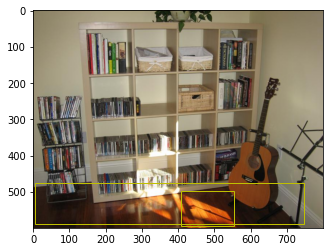

subject:  sun
object:  floor
relation:  ON


In [3]:

def plot_example(idx, re_idx, relations):
    img_id = relations.iloc[idx]['image_id']
    re = relations.iloc[idx]['relationships'][re_idx]
    path = 'visualgeno/VG_100K/{}.jpg'.format(img_id)
    path = path if os.path.isfile(path) else 'visualgeno/VG_100K_2/{}.jpg'.format(img_id)
    img = mpimg.imread(path)
    fig, ax = plt.subplots()
    ax.imshow(img)
    pat_subject = patches.Rectangle((re['subject']['x'],re['subject']['y']),re['subject']['w'],re['subject']['h'],
                            color='y',
                            fill=False)
    pat_object = patches.Rectangle((re['object']['x'],re['object']['y']),re['object']['w'],re['object']['h'],
                            color='y',
                            fill=False)
    ax.add_patch(pat_subject)
    ax.add_patch(pat_object)
    plt.show()
    
    name_pred = re['predicate']
    name_subj = re['subject']['name'] if 'name' in re['subject'] else re['subject']['names']
    name_obj = re['object']['name'] if 'name' in re['object'] else re['object']['names']
    print('subject: ',name_subj)
    print('object: ',name_obj)
    print('relation: ',name_pred)

plot_example(120,1, relations)

In [7]:
relations.shape[0]/3000

36.025666666666666

## Preparing data

In [4]:
def crop_image(img,obj):

    return img[obj['y']:obj['y']+obj['h'],
               obj['x']:obj['x']+obj['w'],:]

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [5]:

resnet = models.resnet101(pretrained=True)
resnet.to(device)
resnet.eval()

data_cut = 3000
Image_batch_size = 20000

data_sect_cnt = 0

for section in range(20):
    data_startpoint = section*data_cut
    
    X,Y = [],[]
    for i in tqdm(range(data_startpoint, data_startpoint+data_cut)):
        img_id = relations.iloc[i]['image_id']
        path = 'visualgeno/VG_100K/{}.jpg'.format(img_id)
        path = path if os.path.isfile(path) else 'visualgeno/VG_100K_2/{}.jpg'.format(img_id)

        img_pred = mpimg.imread(path)
        if len(img_pred.shape)<3:
            continue

        for n, relation in enumerate(relations.iloc[i]['relationships']):
            img_subj = crop_image(img_pred,relation['subject'])
            img_obj = crop_image(img_pred,relation['object'])
            if (0 in img_subj.shape) or (0 in img_obj.shape):
                print('skip one broken image')
                continue

            name_pred = relation['predicate']
            name_subj = relation['subject']['name'] if 'name' in relation['subject'] else relation['subject']['names'][0]
            name_obj = relation['object']['name'] if 'name' in relation['object'] else relation['object']['names'][0]
            X.append([img_pred, img_subj, img_obj])
            Y.append([name_pred, name_subj, name_obj])
            
    
    #looping
    print('X length:', len(X))
    Image_batch_number = np.floor(len(X)/Image_batch_size)

    for start_point in range(0,len(X),Image_batch_size):
        end_point = start_point+Image_batch_size if start_point+Image_batch_size<len(X) else len(X) 

        X_transformed = []
        x_hidden = []
        for row in tqdm(X[start_point:end_point]):
            X_transformed += [transform(img) for img in row]
        X_transformed = torch.cat(X_transformed).reshape((-1,3,224,224)) # the X_transformed is 10000*3*224*224

        x_loader = DataLoader(X_transformed,batch_size=500)
        del X_transformed
        with torch.no_grad():     # have to use no_grad() otherwise there will be memory leck
            output = []
            for x_batch in tqdm(x_loader):
                output_batch = resnet(x_batch.to(device))
                output.append(output_batch)
                
        del x_loader
        x_hidden = torch.cat(output).cpu().reshape((-1,1000)).reshape((-1,3,1000))
        del output
        
        Y_flat = []
        for row in Y[start_point:end_point]:
            Y_flat += row
        Y_flat = np.array(Y_flat)

        pickle.dump(x_hidden, open("data/x_preprocessed_{}.p".format(data_sect_cnt), "wb"))
        pickle.dump(Y_flat, open("data/y_preprocessed_{}.p".format(data_sect_cnt), "wb"))
        data_sect_cnt += 1
        
    
#     pickle.dump(X, open("data/X_{}.p".format(section), "wb"))
#     pickle.dump(Y, open('data/Y_{}.p'.format(section), 'wb'))


 81%|████████  | 2427/3000 [00:36<00:07, 81.62it/s] 

skip one broken image
skip one broken image
skip one broken image


  0%|          | 0/20000 [00:00<?, ?it/s]/home/yl535/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


X length: 53654


  9%|▉         | 273/3000 [00:04<00:29, 93.81it/s] 

skip one broken image
skip one broken image
skip one broken image
skip one broken image
skip one broken image
skip one broken image
skip one broken image


  0%|          | 12/20000 [00:00<02:49, 117.89it/s]

X length: 58506


  0%|          | 20/20000 [00:00<01:42, 194.39it/s]

X length: 42578


  0%|          | 11/20000 [00:00<03:04, 108.56it/s]

X length: 70872


  0%|          | 12/20000 [00:00<02:47, 119.54it/s]

X length: 93188


  0%|          | 13/20000 [00:00<02:35, 128.43it/s]

X length: 77037


  0%|          | 3/20000 [00:00<11:11, 29.78it/s]

X length: 80273


  0%|          | 28/20000 [00:00<01:13, 272.74it/s]

X length: 66138


  0%|          | 13/20000 [00:00<02:37, 127.18it/s]

X length: 64871


  0%|          | 29/20000 [00:00<01:10, 284.15it/s]

X length: 55676


 95%|█████████▌| 2854/3000 [01:48<00:07, 20.68it/s]

skip one broken image
skip one broken image
skip one broken image
skip one broken image


  0%|          | 18/20000 [00:00<01:51, 179.14it/s]

X length: 60127


  0%|          | 2/20000 [00:00<18:08, 18.37it/s]

X length: 62065


  0%|          | 2/20000 [00:00<25:16, 13.19it/s]

X length: 60820


 18%|█▊        | 543/3000 [00:20<01:18, 31.30it/s]

skip one broken image
skip one broken image
skip one broken image


  0%|          | 25/20000 [00:00<01:22, 241.91it/s]

X length: 64266


  0%|          | 11/20000 [00:00<03:07, 106.89it/s]

X length: 67125


  0%|          | 13/20000 [00:00<02:35, 128.54it/s]

X length: 63046


  0%|          | 11/20000 [00:00<03:01, 109.98it/s]

X length: 63285


  0%|          | 14/20000 [00:00<02:26, 135.97it/s]

X length: 62657


  0%|          | 13/20000 [00:00<02:36, 127.71it/s]

X length: 67329


  0%|          | 12/20000 [00:00<02:51, 116.88it/s]

X length: 65617


100%|██████████| 34/34 [00:28<00:00,  1.20it/s]


In [ ]:
# go to filter the datapoint where y predicate is empty

(<matplotlib.image.AxesImage at 0x7f4ebcdc83d0>, 'soil')

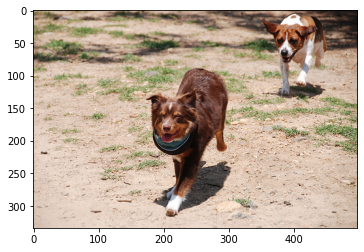

In [15]:
i=8
j=1
plt.imshow(X[i][j]),Y[i][j]

In [16]:
pickle.dump(X, open("X.p", "wb"))
pickle.dump(Y, open('Y.p', 'wb'))